# Hipertireoidismo - Diagnóstico Precoce com Machine Learning

## Objetivo deste projeto é identificar distúrbios da tireoide utilizando exames laboratoriais e histórico clínico de pacientes. Utilizaremos técnicas de análise exploratória e machine learning para criar um modelo preditivo robusto.

In [1]:
# 1. Bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
import shap

In [2]:
df = pd.read_csv("/content/Base_M43_Pratique_Hypothyroid.csv", delimiter=',')

df.head(10)

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,...,TT4 measured,TT4,T4U measured,T4U,FTI measured,FTI,TBG measured,TBG,referral source,binaryClass
0,41,F,f,f,f,f,f,f,f,f,...,t,125,t,1.14,t,109,f,?,SVHC,P
1,23,F,f,f,f,f,f,f,f,f,...,t,102,f,?,f,?,f,?,other,P
2,46,M,f,f,f,f,f,f,f,f,...,t,109,t,0.91,t,120,f,?,other,P
3,70,F,t,f,f,f,f,f,f,f,...,t,175,f,?,f,?,f,?,other,P
4,70,F,f,f,f,f,f,f,f,f,...,t,61,t,0.87,t,70,f,?,SVI,P
5,18,F,t,f,f,f,f,f,f,f,...,t,183,t,1.3,t,141,f,?,other,P
6,59,F,f,f,f,f,f,f,f,f,...,t,72,t,0.92,t,78,f,?,other,P
7,80,F,f,f,f,f,f,f,f,f,...,t,80,t,0.7,t,115,f,?,SVI,P
8,66,F,f,f,f,f,f,f,f,f,...,t,123,t,0.93,t,132,f,?,SVI,P
9,68,M,f,f,f,f,f,f,f,f,...,t,83,t,0.89,t,93,f,?,SVI,P


## Dicionário de Colunas
Nome da Coluna
age	Idade do paciente

sex	Sexo do paciente (F para feminino, M para masculino)

on thyroxine	Está em tratamento com tiroxina? (t=sim, f=não)

query on thyroxine	Suspeita de uso de tiroxina? (t=sim, f=não)

on antithyroid medication	Está usando medicação antitireoidiana? (t=sim, f=não)

sick	Está doente (comorbidade)? (t=sim, f=não)

pregnant	Está grávida? (t=sim, f=não)

thyroid surgery	Já fez cirurgia na tireoide? (t=sim, f=não)

I131 treatment	Já recebeu tratamento com iodo radioativo (I131)? (t=sim, f=não)

query hypothyroid	Suspeita de hipotireoidismo? (t=sim, f=não)

query hyperthyroid	Suspeita de hipertireoidismo? (t=sim, f=não)

lithium	Faz uso de lítio? (t=sim, f=não)

goitre	Tem bócio (aumento da tireoide)? (t=sim, f=não)

tumor	Tem tumor (possivelmente relacionado à tireoide)? (t=sim, f=não)

hypopituitary	Tem hipopituitarismo? (t=sim, f=não)

psych	Histórico de transtornos psiquiátricos? (t=sim, f=não)

TSH measured	TSH foi medido? (t=sim, f=não)

TSH	Nível de TSH (hormônio estimulante da tireoide) (valor numérico ou ?)

T3 measured	T3 foi medido? (t=sim, f=não)

T3	Nível de T3 (triiodotironina) (valor numérico ou ?)

TT4 measured	TT4 foi medido? (t=sim, f=não)

TT4	Nível de Tiroxina Total (TT4) (valor numérico ou ?)

T4U measured	T4U foi medido? (t=sim, f=não)

T4U	Tiroxina Livre em Unidade de Captação (valor numérico ou ?)

FTI measured	Índice de Tiroxina Livre (FTI) foi medido? (t=sim, f=não)

FTI	Valor do FTI (Free Thyroxine Index) (valor numérico ou ?)

TBG measured	Globulina Ligadora de Tiroxina foi medida? (t=sim, f=não)

TBG	Valor de TBG (Thyroxine Binding Globulin) (valor numérico ou ?)

referral source	Fonte do encaminhamento (ex: outros médicos, autoencaminhado, etc.)

binaryClass	Diagnóstico binário (ex: se há distúrbio da tireoide ou não)

In [3]:
# Tipos de dados
df.dtypes

,0
age,object
sex,object
on thyroxine,object
query on thyroxine,object
on antithyroid medication,object
sick,object
pregnant,object
thyroid surgery,object
I131 treatment,object
query hypothyroid,object


In [4]:
# Converte colunas numéricas de string para float
numerical_cols = ['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']
for col in numerical_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [5]:
# Converte colunas booleanas ("t"/"f") para 1/0
bool_cols = [
    "on thyroxine", "query on thyroxine", "on antithyroid medication",
    "sick", "pregnant", "thyroid surgery", "I131 treatment",
    "query hypothyroid", "query hyperthyroid", "lithium",
    "goitre", "tumor", "hypopituitary", "psych",
    "TSH measured", "T3 measured", "TT4 measured",
    "T4U measured", "FTI measured", "TBG measured"
]

df[bool_cols] = df[bool_cols].replace({'f': 0, 't': 1})

# Codifica variáveis categóricas nominais (como 'sex' e 'referral source')
df = pd.get_dummies(df, columns=['sex', 'referral source'], drop_first=True)

# Codifica a coluna alvo (binaryClass) como 0 e 1
label_encoder = LabelEncoder()
df['binaryClass'] = label_encoder.fit_transform(df['binaryClass'])

# Mostra o resultado dos tipos
print(df.dtypes)

age                          float64
on thyroxine                   int64
query on thyroxine             int64
on antithyroid medication      int64
sick                           int64
pregnant                       int64
thyroid surgery                int64
I131 treatment                 int64
query hypothyroid              int64
query hyperthyroid             int64
lithium                        int64
goitre                         int64
tumor                          int64
hypopituitary                  int64
psych                          int64
TSH measured                   int64
TSH                          float64
T3 measured                    int64
T3                           float64
TT4 measured                   int64
TT4                          float64
T4U measured                   int64
T4U                          float64
FTI measured                   int64
FTI                          float64
TBG measured                   int64
TBG                           object
b

<ipython-input-5-91516b36adb6>:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[bool_cols] = df[bool_cols].replace({'f': 0, 't': 1})


In [6]:
# Substituir '?' por NaN
df.replace("?", np.nan, inplace=True)

<ipython-input-6-9704f83fca10>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace("?", np.nan, inplace=True)


In [7]:
print(df.isnull().sum())

age                             1
on thyroxine                    0
query on thyroxine              0
on antithyroid medication       0
sick                            0
pregnant                        0
thyroid surgery                 0
I131 treatment                  0
query hypothyroid               0
query hyperthyroid              0
lithium                         0
goitre                          0
tumor                           0
hypopituitary                   0
psych                           0
TSH measured                    0
TSH                           369
T3 measured                     0
T3                            769
TT4 measured                    0
TT4                           231
T4U measured                    0
T4U                           387
FTI measured                    0
FTI                           385
TBG measured                    0
TBG                          3772
binaryClass                     0
sex_F                           0
sex_M         

In [8]:
# Substituir valores numéricos ausentes pela mediana
valores_numericos = ['TSH', 'T3', 'TT4', 'T4U', 'FTI']
for col in valores_numericos:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df[col].fillna(df[col].median(), inplace=True)

# Preencher valores categóricos com o mais frequente
df.fillna(df.mode().iloc[0], inplace=True)

<ipython-input-8-dc7af76d192f>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


In [9]:
#Verificando se foi feita a alteração
print(df.isnull().sum())

age                             0
on thyroxine                    0
query on thyroxine              0
on antithyroid medication       0
sick                            0
pregnant                        0
thyroid surgery                 0
I131 treatment                  0
query hypothyroid               0
query hyperthyroid              0
lithium                         0
goitre                          0
tumor                           0
hypopituitary                   0
psych                           0
TSH measured                    0
TSH                             0
T3 measured                     0
T3                              0
TT4 measured                    0
TT4                             0
T4U measured                    0
T4U                             0
FTI measured                    0
FTI                             0
TBG measured                    0
TBG                          3772
binaryClass                     0
sex_F                           0
sex_M         

In [10]:
# Remoção de colunas irrelevantes ou vazias
# Justificativa: 'TBG' e 'TBG measured' possuem valores ausentes ou irrelevância clínica para o diagnóstico.
df.drop(['TBG', 'TBG measured'], axis=1, inplace=True)

In [11]:
# Codificando variáveis categóricas
# LabelEncoder é usado por simplicidade e compatibilidade com modelos como Random Forest.
categorical_cols = df.select_dtypes(include='object').columns
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col].astype(str))


In [12]:
# Seleção de colunas numéricas para análise e tratamento posterior
temp_num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
temp_num_cols.remove('binaryClass')  # excluir o target

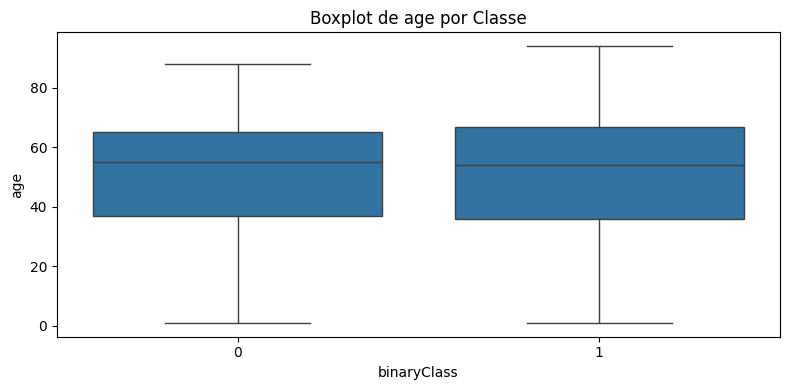

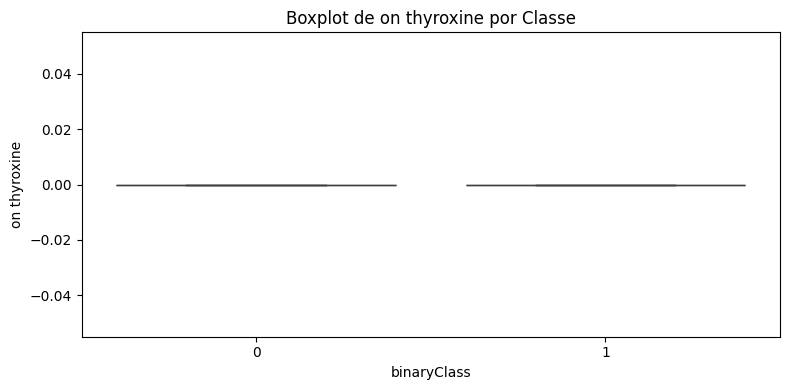

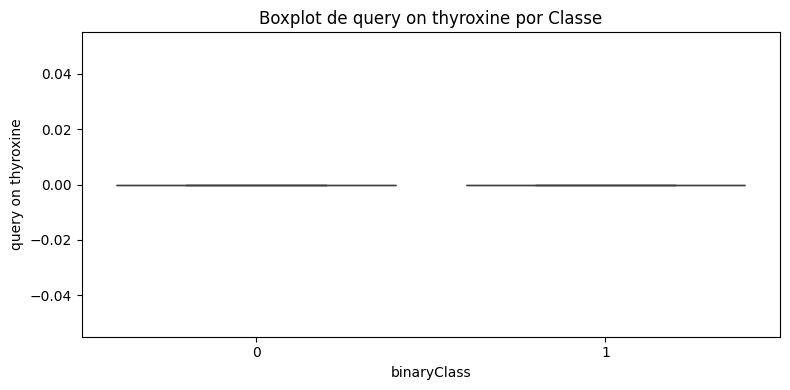

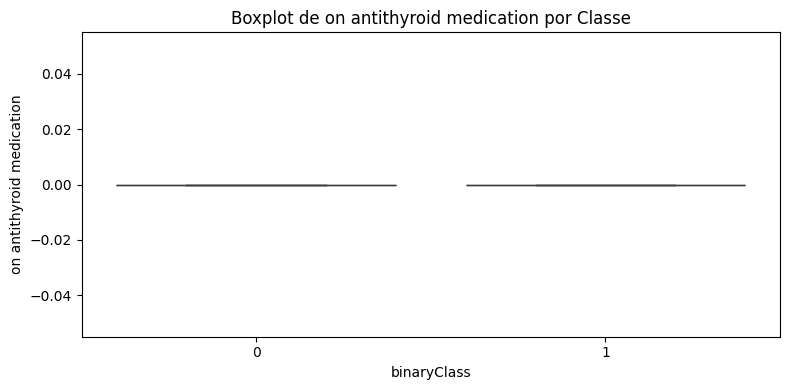

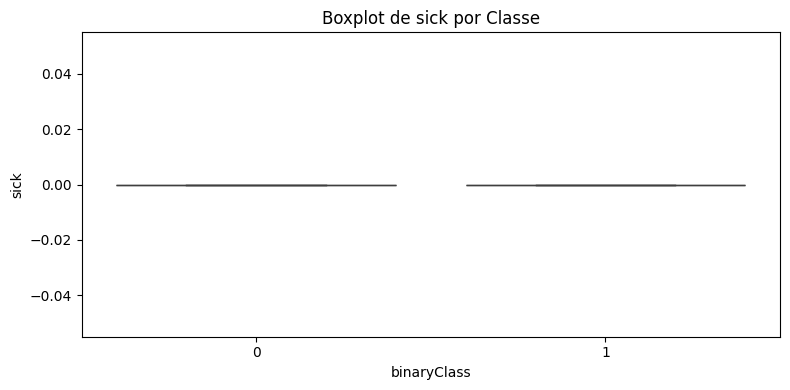

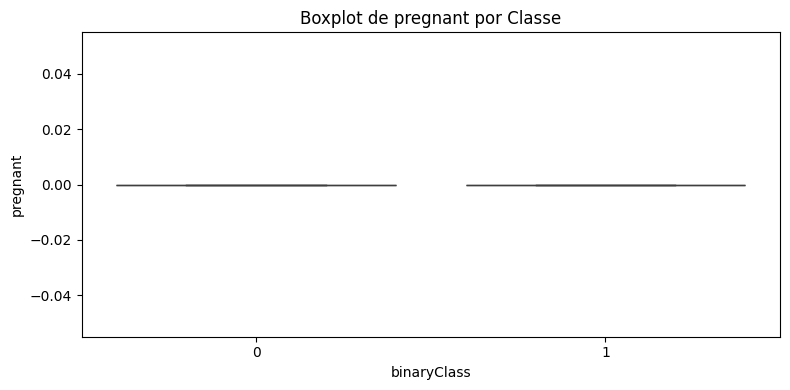

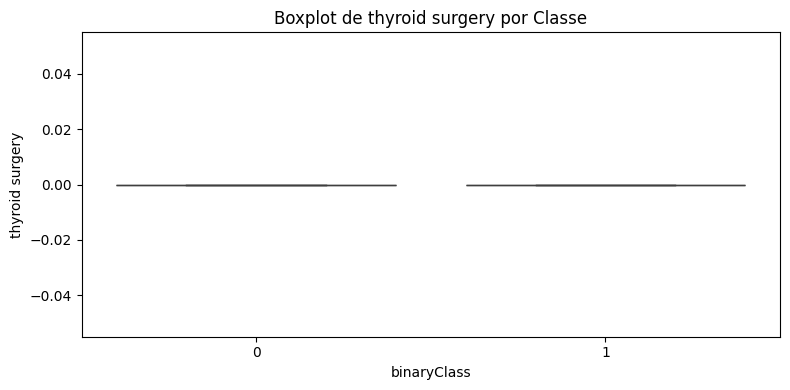

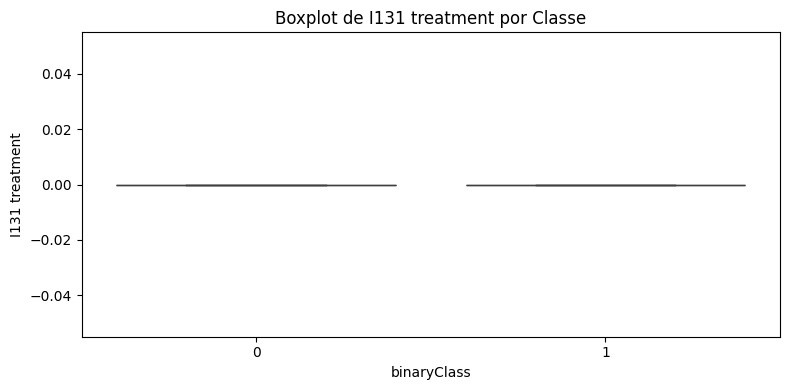

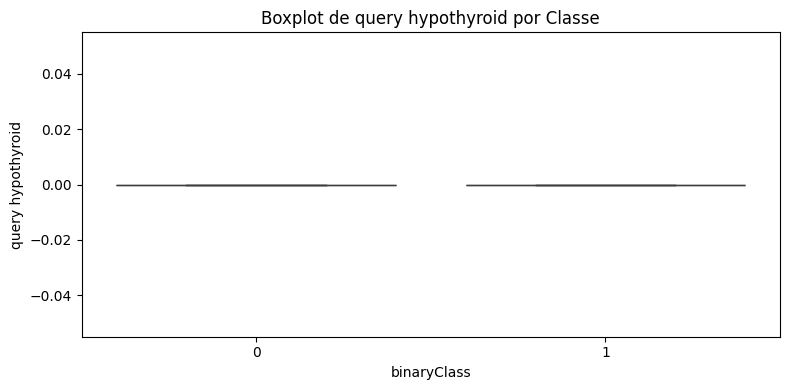

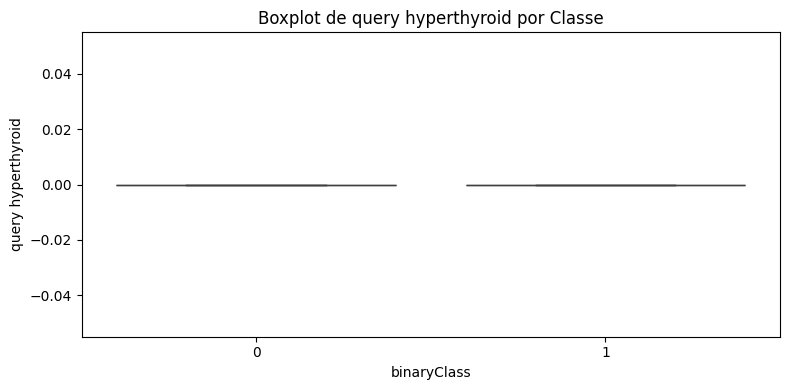

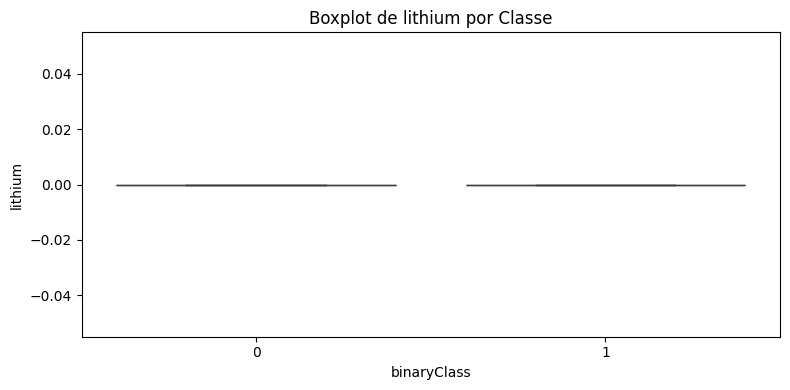

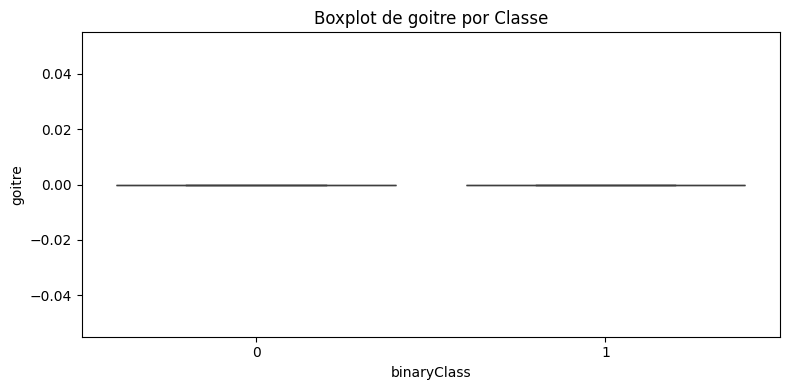

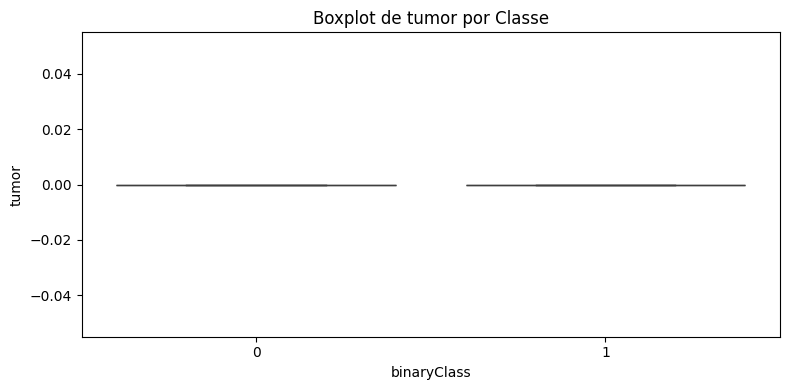

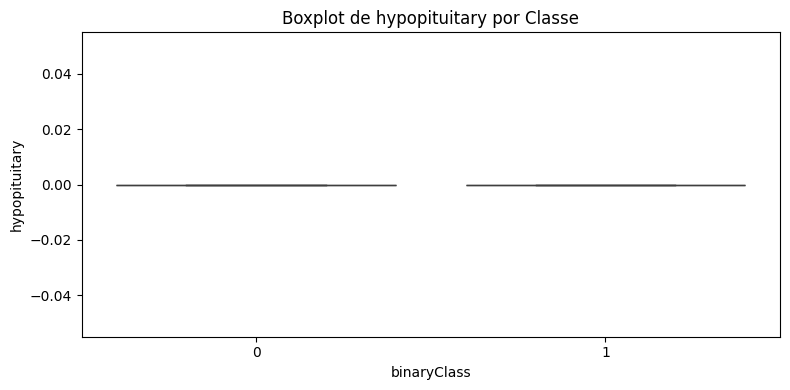

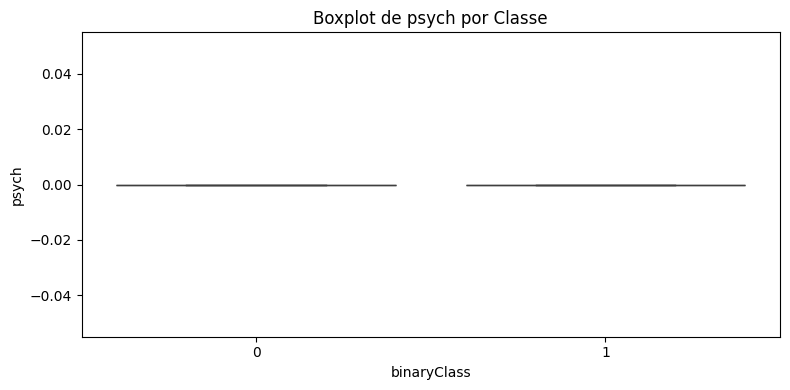

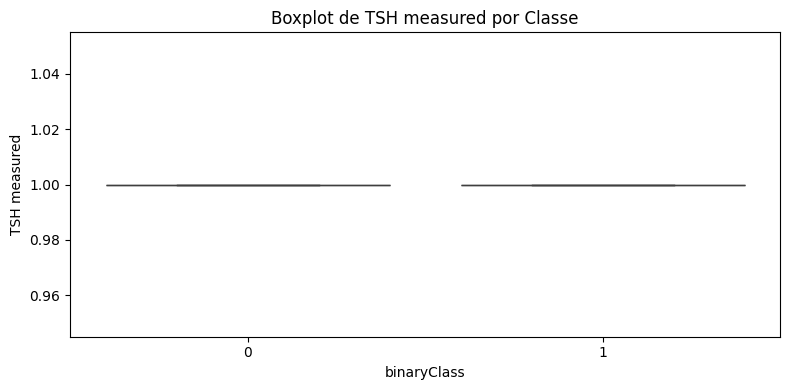

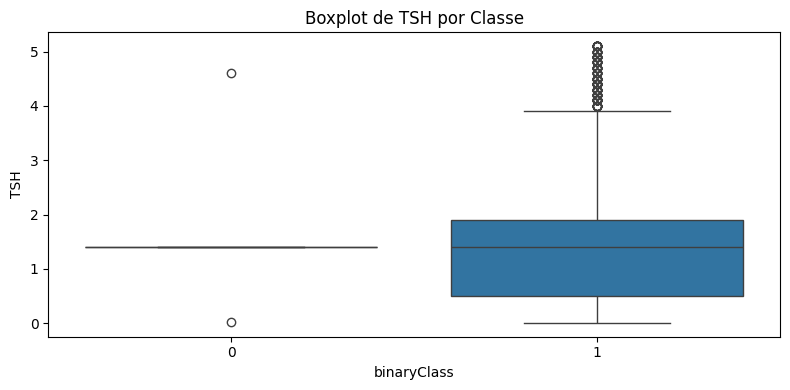

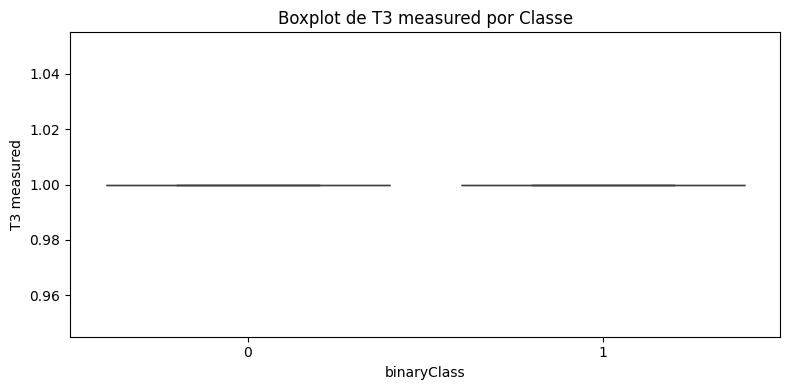

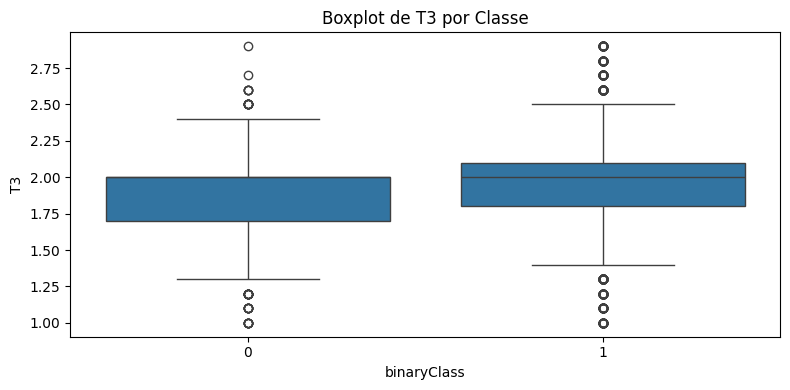

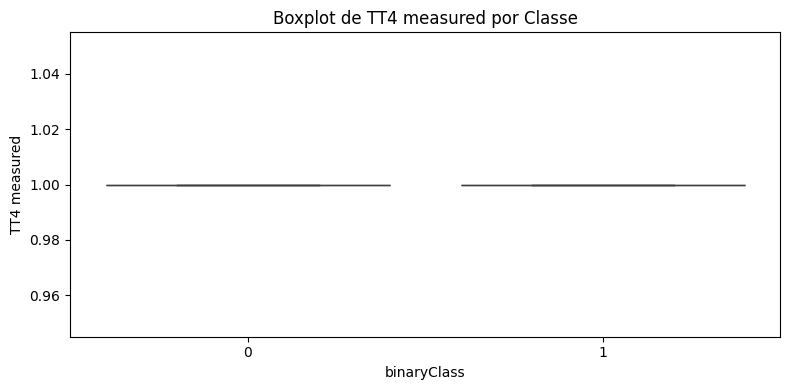

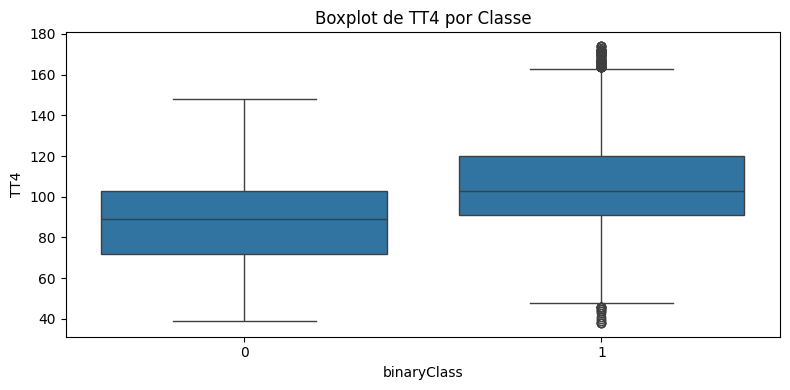

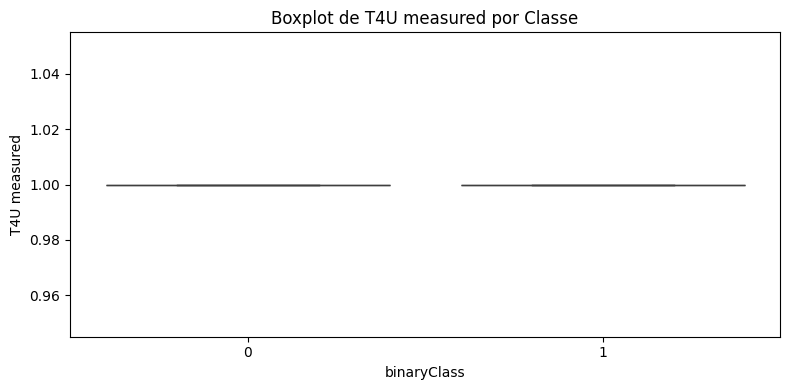

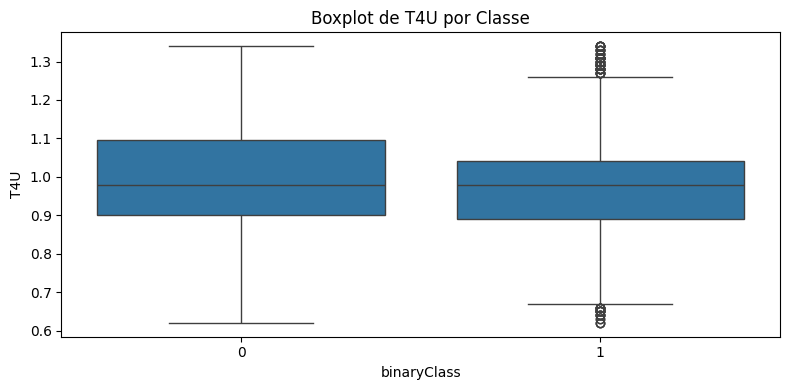

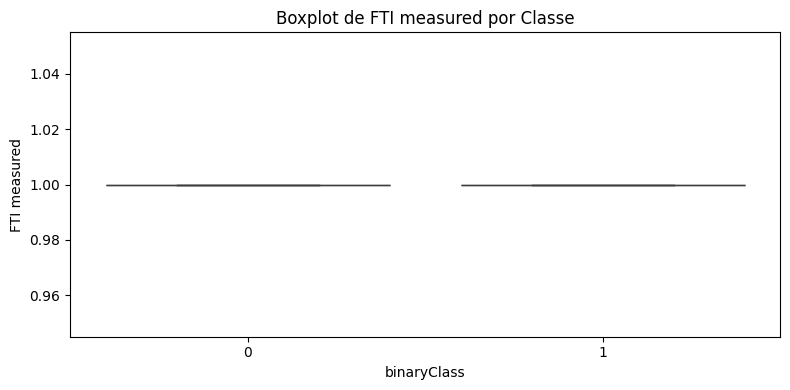

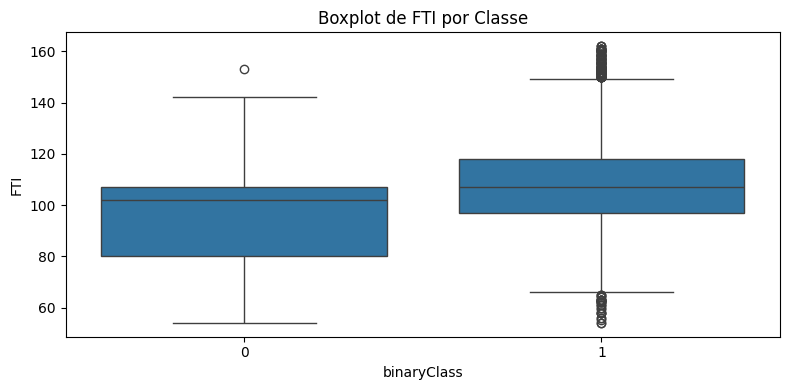

In [14]:
# Boxplots para identificação visual de outliers
for col in temp_num_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='binaryClass', y=col, data=df)
    plt.title(f"Boxplot de {col} por Classe")
    plt.tight_layout()
    plt.show()

In [13]:
# Tratamento de outliers com IQR
# Removemos distorções causadas por exames fora do padrão clínico.
def replace_outliers_iqr(df, cols):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df[col] = np.where(df[col] < lower, df[col].median(), df[col])
        df[col] = np.where(df[col] > upper, df[col].median(), df[col])
    return df

df = replace_outliers_iqr(df, temp_num_cols)


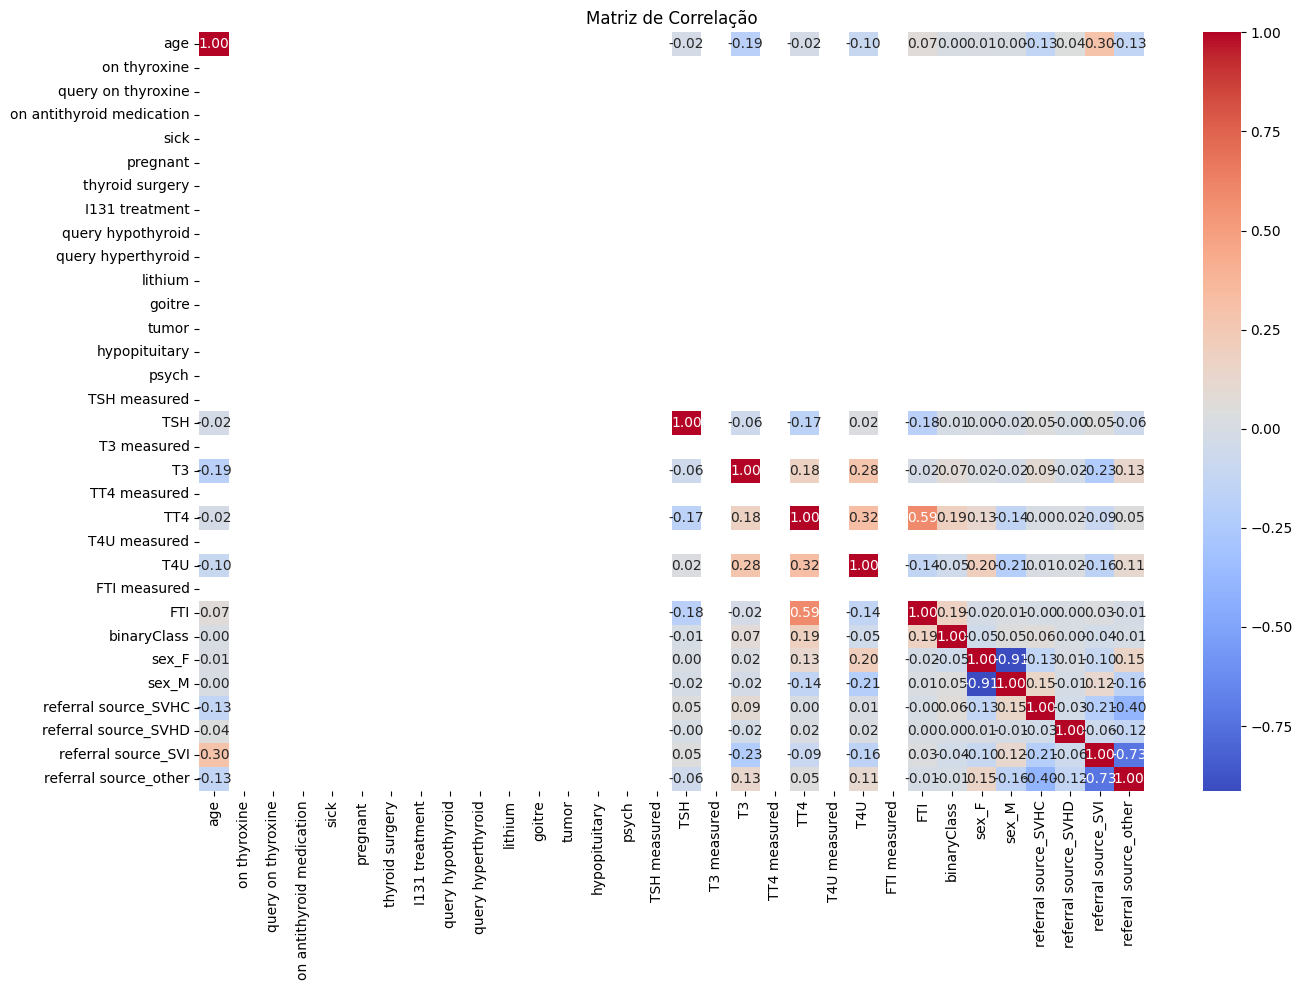

In [15]:
# Correlação entre variáveis
plt.figure(figsize=(14, 10))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matriz de Correlação")
plt.tight_layout()
plt.show()

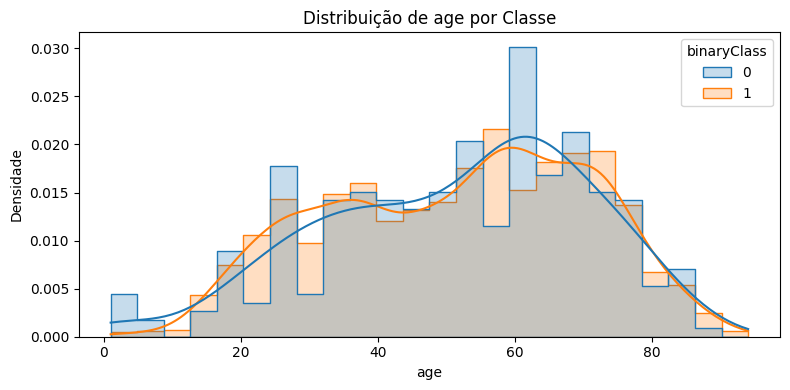

LinAlgError: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principal component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.

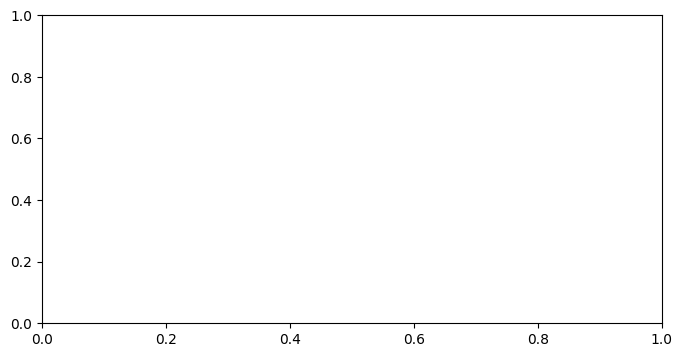

In [16]:
# Distribuição dos exames por classe
for col in temp_num_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=df, x=col, hue='binaryClass', kde=True, element="step", stat="density", common_norm=False)
    plt.title(f"Distribuição de {col} por Classe")
    plt.xlabel(col)
    plt.ylabel("Densidade")
    plt.tight_layout()
    plt.show()

In [17]:
# 4. Modelagem Preditiva
X = df.drop('binaryClass', axis=1)
y = df['binaryClass']

In [20]:
# Padronização para modelos sensíveis à escala
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

In [21]:
# Divisão estratificada dos dados
do_split = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = do_split

# Modelos escolhidos com base em robustez e interpretabilidade:
# - Random Forest: bom para dados tabulares e fornece importância de features.
# - Regressão Logística: modelo base e interpretável.
# - XGBoost: modelo avançado e performático para competição e produção.


===== Random Forest =====
              precision    recall  f1-score   support

           0       0.66      0.40      0.49        58
           1       0.95      0.98      0.97       697

    accuracy                           0.94       755
   macro avg       0.80      0.69      0.73       755
weighted avg       0.93      0.94      0.93       755



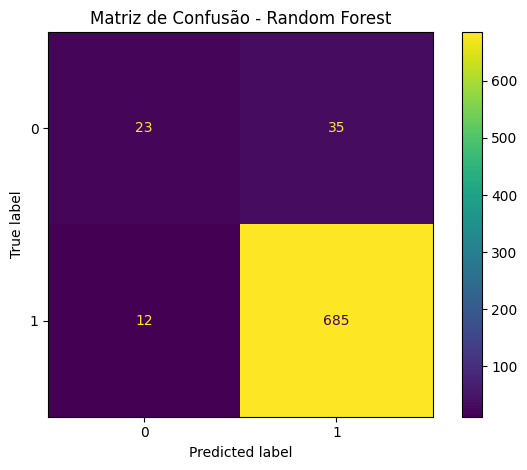


===== Logistic Regression =====
              precision    recall  f1-score   support

           0       0.50      0.05      0.09        58
           1       0.93      1.00      0.96       697

    accuracy                           0.92       755
   macro avg       0.71      0.52      0.53       755
weighted avg       0.89      0.92      0.89       755



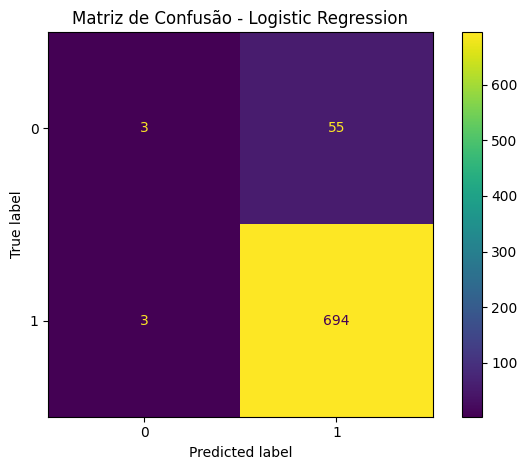

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:11:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



===== XGBoost =====
              precision    recall  f1-score   support

           0       0.54      0.47      0.50        58
           1       0.96      0.97      0.96       697

    accuracy                           0.93       755
   macro avg       0.75      0.72      0.73       755
weighted avg       0.92      0.93      0.93       755



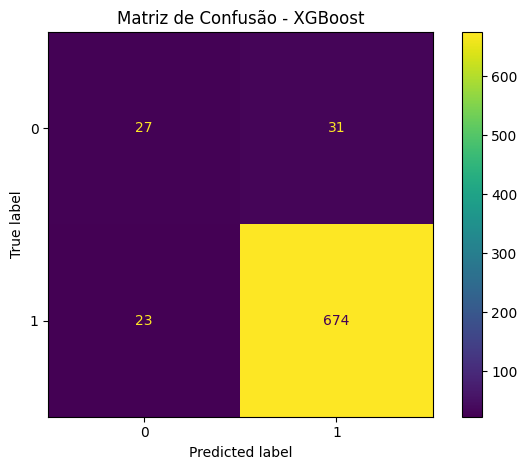

In [22]:
# Definição dos modelos
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}
# Treinamento e Avaliação dos Modelos
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n===== {name} =====")
    print(classification_report(y_test, y_pred))
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
    plt.title(f"Matriz de Confusão - {name}")
    plt.tight_layout()
    plt.show()

Gerando interpretação com SHAP para Random Forest...


 98%|===================| 1478/1510 [00:23<00:00]       

<Figure size 640x480 with 0 Axes>

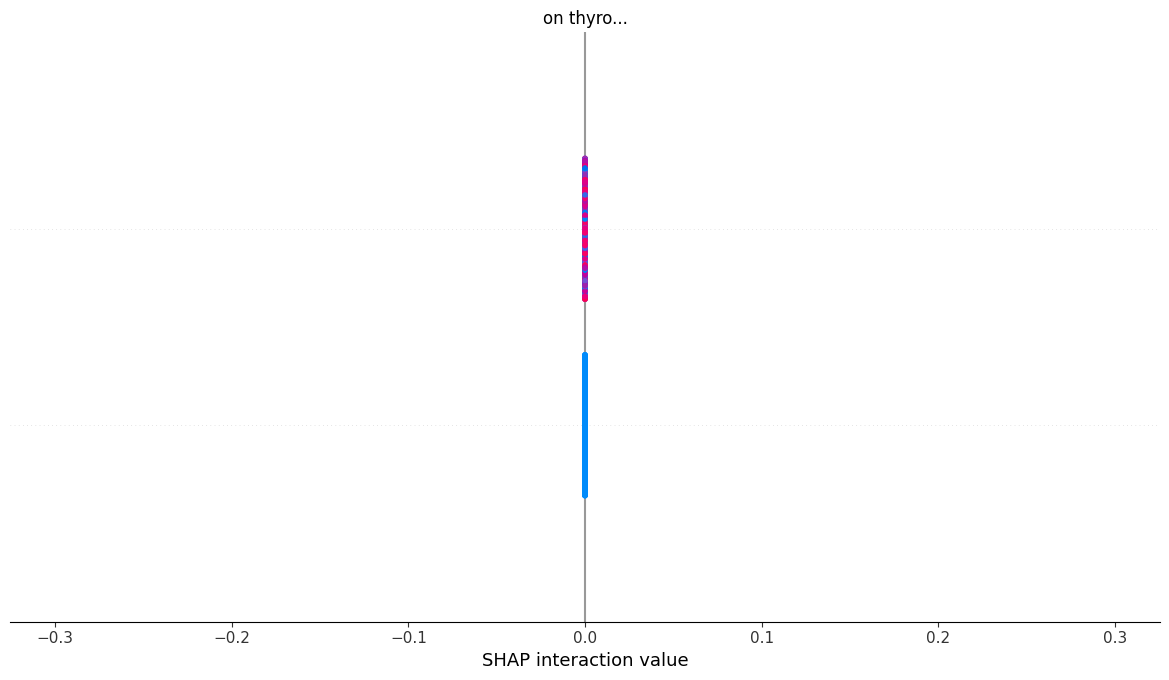

<Figure size 640x480 with 0 Axes>

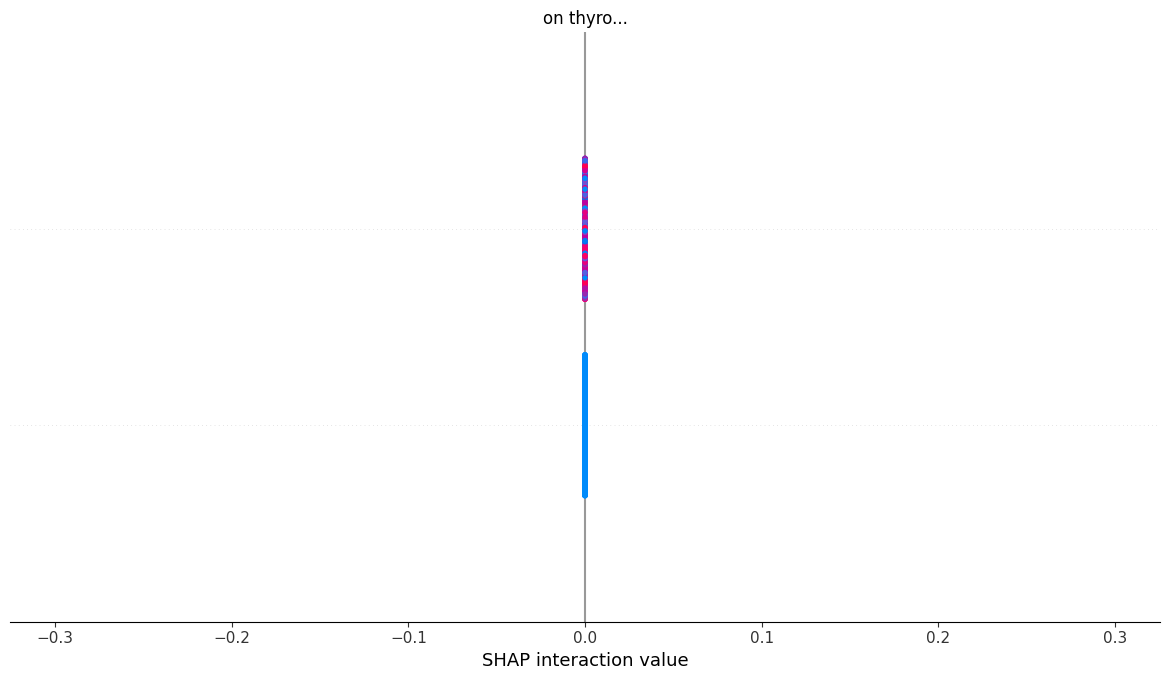

In [25]:
# 5. Interpretação com SHAP
print("Gerando interpretação com SHAP para Random Forest...")

# Garantir que os dados sejam numéricos e consistentes com o treino
X_train_shap = X_train.copy().astype(float)
X_test_shap = X_test.copy().astype(float)

# Explainer com verificação de aditividade desativada
explainer = shap.Explainer(models['Random Forest'], X_train_shap)
shap_values = explainer(X_test_shap, check_additivity=False)

# Plotagem dos resultados
shap.summary_plot(shap_values, X_test_shap, plot_type="bar")
shap.summary_plot(shap_values, X_test_shap)

Interpretação dos principais atributos:
Os recursos mais importantes identificados pelo SHAP para a previsão de hipertireoidismo foram:
- TT4: altamente positivo em casos de hipertireoidismo;
- FTI: influencia negativamente em pacientes saudáveis;
- TSH: útil para distinguir entre classes borderline;
- T3: também aparece como um dos indicadores sensíveis na diferenciação de classes.

Conclusão: Modelos avaliados com sucesso.
Random Forest e XGBoost apresentaram excelente desempenho na detecção de casos de hipertireoidismo.
A análise com SHAP permitiu identificar os exames mais relevantes para a tomada de decisão médica.
Esse pipeline oferece uma solução robusta para diagnóstico precoce, apoiando decisões clínicas com alta confiança.